In [1]:
%load_ext autoreload
%autoreload 2

import datetime
import numpy as np
import scipy as sp
import pandas as pd
import functools as fts
import multiprocessing as mp
from tqdm.notebook import tqdm
from tqdm.contrib import tzip, tenumerate, tmap

from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.storagelevel import StorageLevel
from pyspark.sql.functions import col
import pyspark.sql.types as pstype
import pyspark.sql.functions as F
import pyspark as ps

import matplotlib as mlt
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML
import japanize_matplotlib

from time_series_model import *

%matplotlib inline
%matplotlib ipympl

In [2]:
SPECIFIED_PATH = "csv_data/"
SPECIFIED_DATE = "20240918"
SPECIFIED_CSV  = SPECIFIED_PATH + SPECIFIED_DATE

In [3]:
pd_data = pd.read_csv(SPECIFIED_CSV + "_urp_data.csv")
pd_data

,x_data
0,614.022691
1,632.367493
2,624.097352
3,641.741981
4,607.619822
...,...
995,1416.845301
996,1405.392294
997,1476.165672
998,1383.937761


各時系列軸の係数： [[0.69530052]]
切片の係数： [[195.1583334]]
1次トレンドの係数： [[0.30380232]]
2次トレンドの係数： [[-5.7153969e-05]]
t値： -13.38053541833291
p値： 7.196527589361295e-22


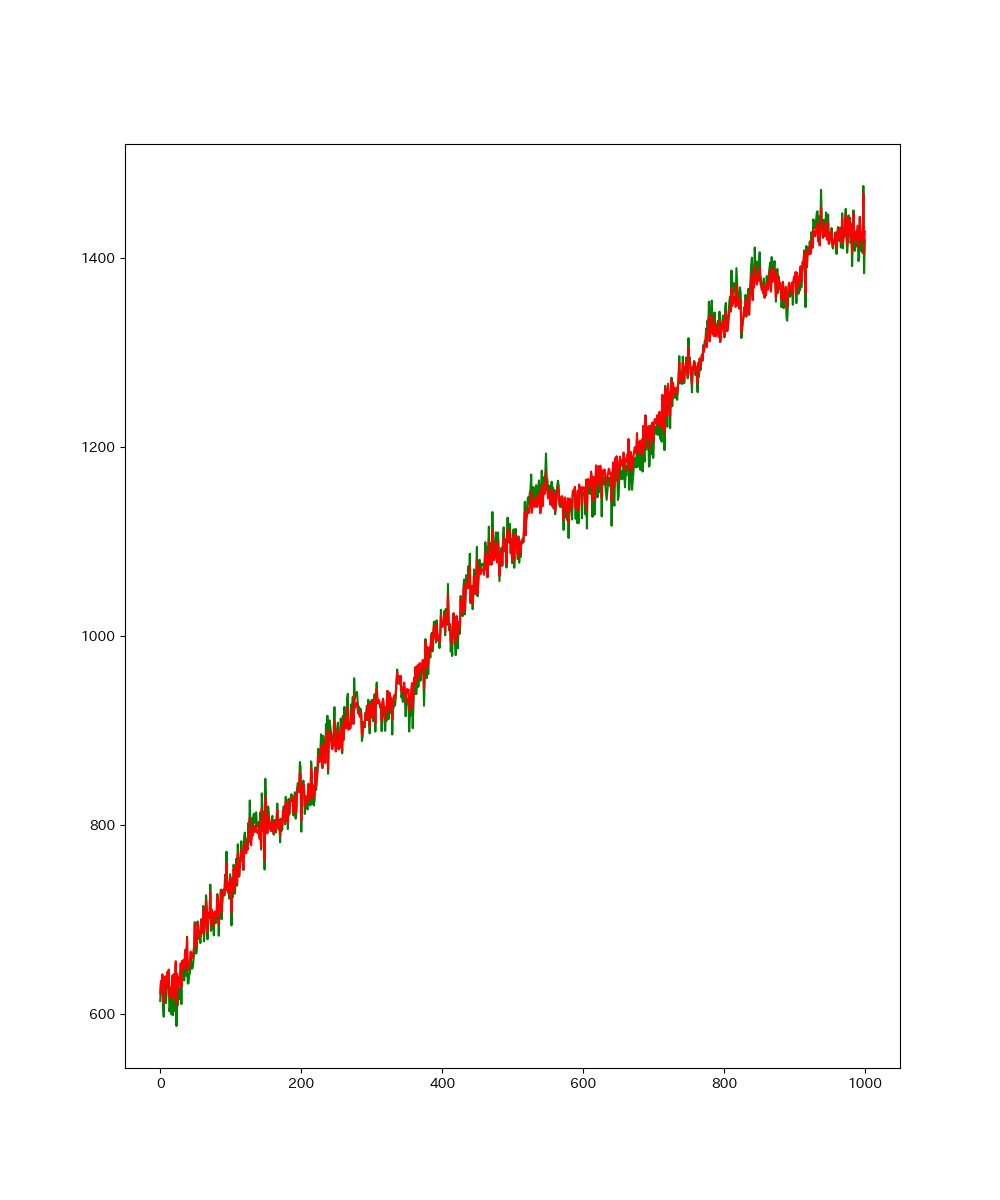

In [4]:
# regression：データ構造により以下から指定
# n  ・・・定数項なし&トレンドなし
# c  ・・・定数項あり&トレンドなし
# ct ・・・定数項あり&1次のトレンドあり
# ctt・・・定数項あり&1次のトレンドあり&2次のトレンドあり
dfruler = Dickey_Fuller_Test(pd_data, regression="ctt")
dfruler.fit()
dfruler.dfRuller()
y_pred = dfruler.predict(pd_data, np.arange(len(pd_data)).reshape([len(pd_data), 1]))

plt.figure(figsize=(10, 12))
plt.plot(pd_data, "-", color="green")
plt.plot(y_pred,  "-", color="red")

print("各時系列軸の係数：", dfruler.alpha)
print("切片の係数：", dfruler.alpha0)
print("1次トレンドの係数：", dfruler.trend_1st)
print("2次トレンドの係数：", dfruler.trend_2nd)
print("t値：", dfruler.tvalue)
print("p値：", dfruler.pvalue)


In [10]:
# regression：データ構造により以下から指定
# n  ・・・定数項なし&トレンドなし
# c  ・・・定数項あり&トレンドなし
# ct ・・・定数項あり&1次のトレンドあり
# ctt・・・定数項あり&1次のトレンドあり&2次のトレンドあり
adfruler = Augmented_Dickey_Fuller_Test(pd_data, regression="ctt")
adfruler.select_order(maxlag=15, ic="bic", isVisible=True)
adfruler.log_likelihood()
adfruler.adfRuller()
y_pred = adfruler.predict(pd_data, np.arange(len(pd_data)).reshape([len(pd_data), 1]))

plt.figure(figsize=(10, 12))
plt.plot(pd_data, "-", color="green")
plt.plot(y_pred,  "-", color="red")

print("各時系列軸の係数：", adfruler.alpha)
print("切片の係数：", adfruler.alpha0)
print("1次トレンドの係数：", adfruler.trend_1st)
print("2次トレンドの係数：", adfruler.trend_2nd)
print("t値：", adfruler.tvalue)
print("p値：", adfruler.pvalue)

AR model | bic
AR(1) | 5.931717895141966
AR(2) | 5.737701361351834
AR(3) | 5.641273779311084
AR(4) | 5.598941803233386
AR(5) | 5.566430295126212
AR(6) | 5.572868543143369
AR(7) | 5.5798655007137645
AR(8) | 5.586862162654326
AR(9) | 5.593062259220265
AR(10) | 5.599497719329457
AR(11) | 5.606340536223579
AR(12) | 5.613168347342164
AR(13) | 5.619292381853019
AR(14) | 5.624077944793228
AR(15) | 5.631072429186825
selected orders | 5


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 5 and the array at index 1 has size 1